In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


In [2]:

# Function to generate synthetic data
def generate_synthetic_data(num_records=6000, start_date='2023-06-01', end_date='2023-12-01'):
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')

    # List of service names
    services = ['order-srv-1', 'order-srv-2', 'vendor-srv-1', 'vendor-srv-2']

    data = []
    for _ in range(num_records):
        timestamp = random.choice(date_range)
        service_name = random.choice(services)
        cpu_usage = random.uniform(30, 100)
        memory_usage = random.uniform(30, 100)

        data.append([timestamp, service_name, cpu_usage, memory_usage])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'service_name', 'cpu_usage', 'memory_usage'])
    return df

# Generate synthetic data
synthetic_data = generate_synthetic_data(num_records=6000)

# Save synthetic data to CSV
synthetic_data.to_csv('synthetic_data.csv', index=False)

# Display the first few records of the generated data
synthetic_data.head()


<ipython-input-2-227b0d2e280b>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='H')


,timestamp,service_name,cpu_usage,memory_usage
0,2023-07-12 16:00:00,order-srv-1,76.972674,98.478248
1,2023-06-15 11:00:00,vendor-srv-1,77.773707,71.510762
2,2023-06-06 09:00:00,vendor-srv-1,32.395604,50.914579
3,2023-08-11 16:00:00,vendor-srv-1,39.414607,59.468899
4,2023-11-06 06:00:00,order-srv-2,32.250328,67.538365


In [3]:

# Load the synthetic data
synthetic_data = pd.read_csv('synthetic_data.csv')

# Convert timestamp to datetime
synthetic_data['timestamp'] = pd.to_datetime(synthetic_data['timestamp'])

# Sort the data by timestamp
synthetic_data.sort_values(by='timestamp', inplace=True)

# Handle missing values
synthetic_data.fillna(method='ffill', inplace=True)

# Display the cleaned data
synthetic_data.head()

<ipython-input-3-843abf3f4313>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  synthetic_data.fillna(method='ffill', inplace=True)


,timestamp,service_name,cpu_usage,memory_usage
577,2023-06-01 00:00:00,order-srv-2,90.203739,64.405154
4326,2023-06-01 00:00:00,order-srv-1,47.313691,71.407633
2137,2023-06-01 03:00:00,order-srv-1,67.690851,66.455244
352,2023-06-01 04:00:00,order-srv-2,90.662618,32.924597
360,2023-06-01 05:00:00,vendor-srv-1,94.677662,71.648212


In [4]:
# ------------------ kNN Anomaly Detection ------------------

# Prepare features for anomaly detection
metrics_features = synthetic_data[['cpu_usage', 'memory_usage']]

# Set the number of neighbors (k)
k = 5

# Fit the kNN model
knn = NearestNeighbors(n_neighbors=k)
knn.fit(metrics_features)

# Compute the distances to the k nearest neighbors
distances, _ = knn.kneighbors(metrics_features)

# Calculate the mean distance to the k nearest neighbors
mean_distances = distances.mean(axis=1)

# Set a threshold for anomalies (e.g., 95th percentile of distances)
threshold = np.percentile(mean_distances, 95)

# Classify anomalies
synthetic_data['anomaly'] = (mean_distances > threshold).astype(int)


In [5]:
# ------------------ Filter Detected Anomalies ------------------

# Filter detected anomalies
detected_anomalies = synthetic_data[synthetic_data['anomaly'] == 1]

# Separate anomalies for CPU and memory usage (optional)
cpu_anomalies = detected_anomalies[detected_anomalies['cpu_usage'] > detected_anomalies['memory_usage']]
memory_anomalies = detected_anomalies[detected_anomalies['memory_usage'] > detected_anomalies['cpu_usage']]

# Print detected CPU anomalies
print("\nDetected CPU Anomalies:")
print(cpu_anomalies[['timestamp', 'service_name', 'cpu_usage']])

# Print detected Memory anomalies
print("\nDetected Memory Anomalies:")
print(memory_anomalies[['timestamp', 'service_name', 'memory_usage']])





Detected CPU Anomalies:
               timestamp  service_name  cpu_usage
2377 2023-06-01 17:00:00  vendor-srv-1  84.916477
3232 2023-06-03 10:00:00  vendor-srv-2  67.515262
2781 2023-06-03 13:00:00   order-srv-1  42.268471
5587 2023-06-03 23:00:00   order-srv-2  74.567325
221  2023-06-05 09:00:00   order-srv-1  98.488601
...                  ...           ...        ...
2172 2023-11-22 06:00:00  vendor-srv-1  76.978031
872  2023-11-22 09:00:00  vendor-srv-1  97.551750
2610 2023-11-23 05:00:00  vendor-srv-1  54.576872
1971 2023-11-28 00:00:00   order-srv-2  60.541248
5210 2023-11-29 19:00:00   order-srv-2  54.859545

[152 rows x 3 columns]

Detected Memory Anomalies:
               timestamp  service_name  memory_usage
4326 2023-06-01 00:00:00   order-srv-1     71.407633
2541 2023-06-01 10:00:00  vendor-srv-1     62.422854
5977 2023-06-02 04:00:00  vendor-srv-2     91.873898
64   2023-06-06 18:00:00   order-srv-1     46.036199
5426 2023-06-08 09:00:00   order-srv-2     91.595879
...  

In [6]:
# Combine all detected anomalies into a single DataFrame
all_anomalies = pd.concat([
    cpu_anomalies[['timestamp', 'service_name', 'cpu_usage']],
    memory_anomalies[['timestamp', 'service_name', 'memory_usage']]
])

# Save the anomalies to a CSV file
all_anomalies.to_csv('knn_detected_anomalies.csv', index=False)

# Print all detected anomalies
print("\nAll Detected Anomalies:")
print(all_anomalies)


All Detected Anomalies:
               timestamp  service_name  cpu_usage  memory_usage
2377 2023-06-01 17:00:00  vendor-srv-1  84.916477           NaN
3232 2023-06-03 10:00:00  vendor-srv-2  67.515262           NaN
2781 2023-06-03 13:00:00   order-srv-1  42.268471           NaN
5587 2023-06-03 23:00:00   order-srv-2  74.567325           NaN
221  2023-06-05 09:00:00   order-srv-1  98.488601           NaN
...                  ...           ...        ...           ...
4470 2023-11-25 15:00:00   order-srv-1        NaN     90.102145
4081 2023-11-26 18:00:00   order-srv-1        NaN     73.520133
2555 2023-11-27 11:00:00   order-srv-1        NaN     87.320647
1332 2023-11-28 12:00:00  vendor-srv-1        NaN     82.957176
5463 2023-11-29 15:00:00  vendor-srv-1        NaN     91.181581

[300 rows x 4 columns]


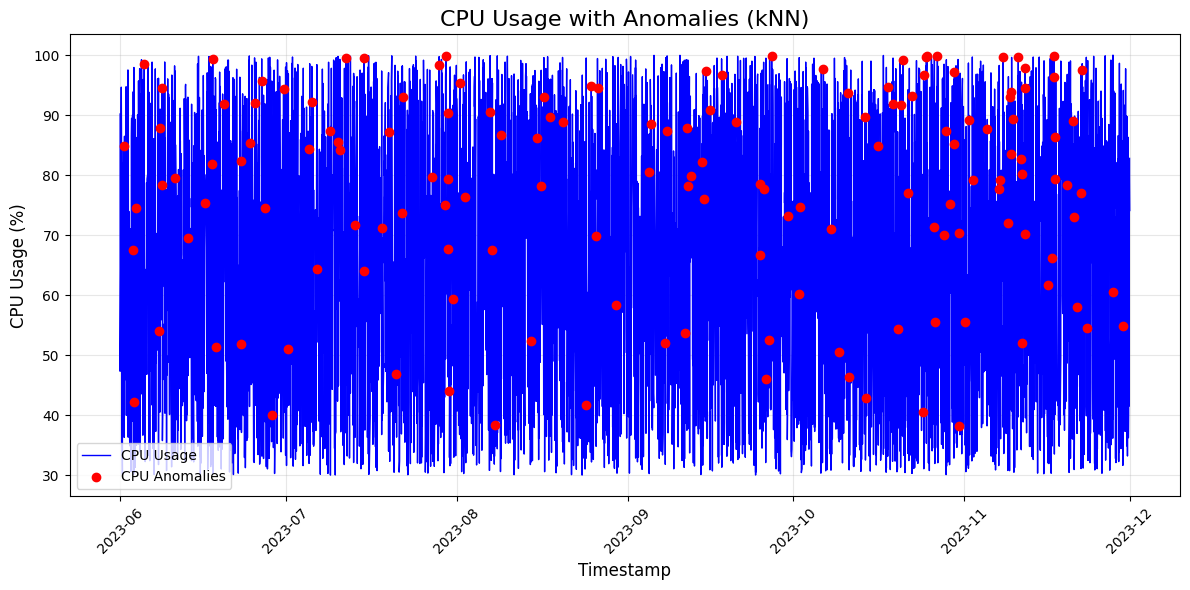

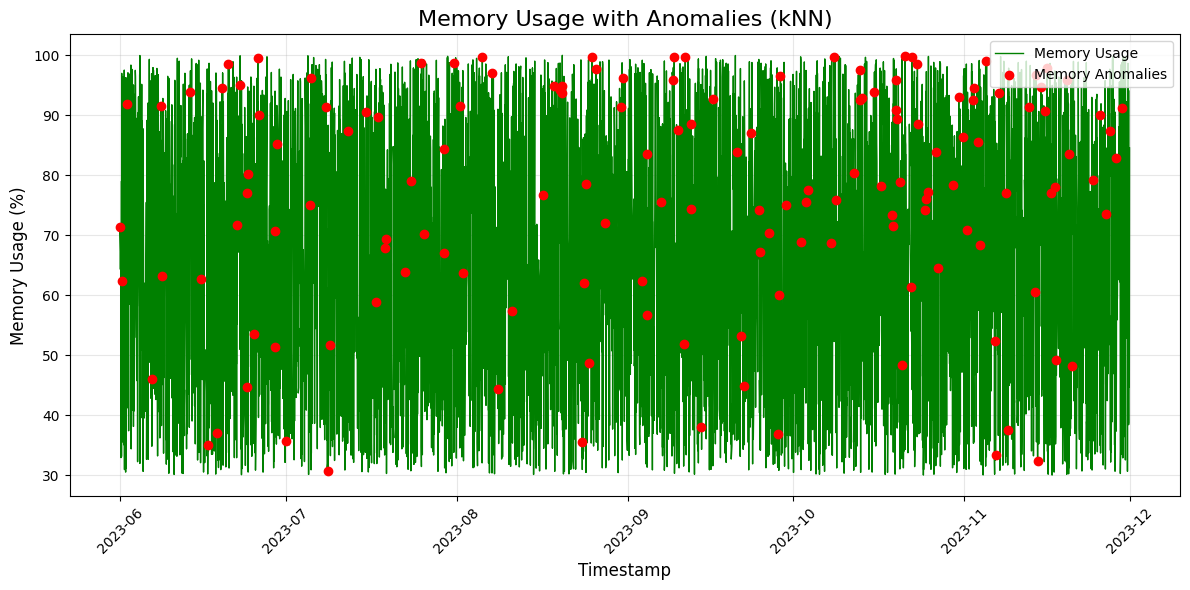

In [7]:
# ------------------ Visualize Anomalies ------------------

# Plot CPU usage and highlight anomalies
plt.figure(figsize=(12, 6))
plt.plot(synthetic_data['timestamp'], synthetic_data['cpu_usage'], label='CPU Usage', color='blue', linewidth=1)
plt.scatter(cpu_anomalies['timestamp'], cpu_anomalies['cpu_usage'], color='red', label='CPU Anomalies', zorder=3)
plt.title('CPU Usage with Anomalies (kNN)', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('CPU Usage (%)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Memory usage and highlight anomalies
plt.figure(figsize=(12, 6))
plt.plot(synthetic_data['timestamp'], synthetic_data['memory_usage'], label='Memory Usage', color='green', linewidth=1)
plt.scatter(memory_anomalies['timestamp'], memory_anomalies['memory_usage'], color='red', label='Memory Anomalies', zorder=3)
plt.title('Memory Usage with Anomalies (kNN)', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Memory Usage (%)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()